In [345]:
import pandas as pd
import geopandas as gp
import plotly.express as px
import fiona

from itables import show
from pprint import pprint

In [4]:
crop_codes_df = pd.read_csv('cropland_codes.csv')
crop_codes = dict(zip(crop_codes_df['Codes'].values, crop_codes_df['Class_Names'].values))

crop_codes_rename = {'C_NODATA': 'Unknown'}
for code, crop in crop_codes.items():
    if crop != ' ':
        crop_codes_rename[f'C_{code}'] = crop

### NY Counties

In [232]:
nycounties_path = r'QGIS/Counties.gpkg'

nycounties_df = gp.read_file(nycounties_path, layer='NyCounties')

#show(nycounties_df)

In [290]:
nycounts_path = r'QGIS/NyCropCounts.gpkg'

nytables = {}
for layer in fiona.listlayers(nycounts_path):
    nytables[layer] = gp.read_file(nycounts_path, layer=layer)
    
#nytables

In [291]:
for name, table in nytables.items():
    table['Year'] = int(name[-4:])
    nytables[name] = table

nycounts_df = pd.concat(nytables.values())
nycounts_df = nycounts_df.copy() #I was getting a performance warning from Pandas

nycounts_df['State'] = 'NY'
nycounts_df = nycounts_df.drop(columns='geometry') #This can be joined back later
nycounts_df = nycounts_df.drop(columns='COUNTYNS')
nycounts_df = pd.merge(nycounts_df, nycounties_df[['COUNTYFP', 'NAME']], how='left', on='COUNTYFP')
nycounts_df = nycounts_df.rename(columns={'NAME': 'County Name'})
nycounts_df = nycounts_df.fillna(value=0)

nycols = list(nycounts_df.columns)
nycols.remove('State')
nycols.insert(1, 'State')
nycols.remove('County Name')
nycols.insert(3, 'County Name')
nycols.remove('Year')
nycols.insert(4, 'Year')
nycols.remove('C_NODATA')
nycols.append('C_NODATA')
nycounts_df = nycounts_df[nycols]

for col in nycols:
    if col.startswith('C_'):
        nycounts_df[col] = nycounts_df[col].astype('int')

In [292]:
show(nycounts_df.dtypes)

In [293]:
show(nycounts_df)

In [295]:
nycounts_df = nycounts_df.rename(columns=crop_codes_rename)
show(nycounts_df)

In [372]:
nycounts_df.to_csv('NyCropCounts.csv', index=False)

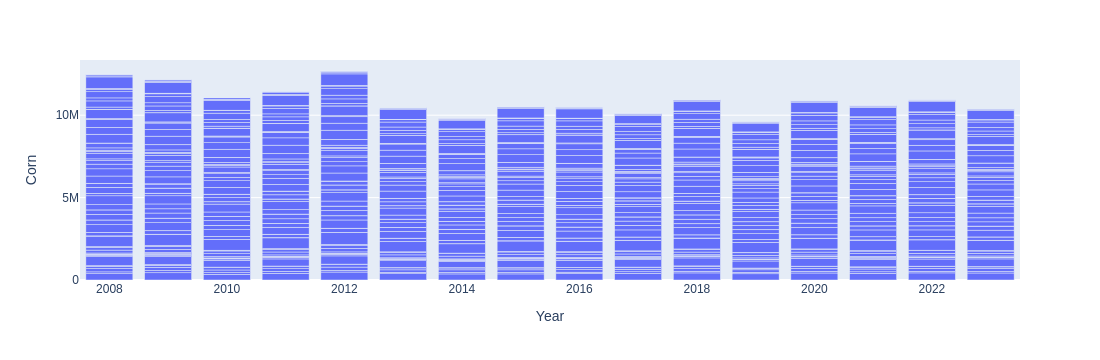

In [312]:
fig = px.bar(
    nycounts_df,
    x='Year',
    y='Corn',
    
)

fig.show()

### CA Counties

In [365]:
cacounts_path = r'QGIS/CaCropCounts.gpkg'

catables = {}
for layer in fiona.listlayers(cacounts_path):
    year = int(layer[-4:])

    table = gp.read_file(cacounts_path, layer=layer)

    table = table.drop(columns='geometry')
    table['Year'] = year
    
    catables[layer] = table
    
cacounts_df = pd.concat(catables.values())
cacounts_df = cacounts_df.drop(columns=['COUNTYNS', 'NAMELSAD', 'STATEFP', 'GEOID', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'])

cacounts_df = cacounts_df.fillna(0)
cacounts_df = cacounts_df.rename(columns=crop_codes_rename)
cacounts_df = cacounts_df.rename(columns={'NAME': 'County Name'})

cacounts_df['State'] = 'CA'

cacols = list(cacounts_df.columns)
cacols.remove('State')
cacols.insert(0, 'State')
cacols.remove('Year')
cacols.insert(2, 'Year')
cacols.remove('Unknown')
cacols.append('Unknown')

cacounts_df = cacounts_df[cacols]

show(cacounts_df)

In [375]:
cacounts_df.to_csv('CaCropCounts.csv', index=False)